In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras_preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Data"

In [4]:
%cd /content/gdrive/MyDrive/Data

/content/gdrive/MyDrive/Data


In [5]:
!kaggle datasets download -d theblackmamba31/landscape-image-colorization

landscape-image-colorization.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip /content/gdrive/MyDrive/Data/landscape-image-colorization.zip

Archive:  /content/gdrive/MyDrive/Data/landscape-image-colorization.zip
replace landscape Images/color/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
color_img = []
path = '/content/gdrive/MyDrive/Data/landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '4500.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))


gray_img = []
path = '/content/gdrive/MyDrive/Data/landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '4500.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))

 63%|██████▎   | 4500/7129 [00:19<00:11, 232.86it/s]


In [3]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
   
    plt.show()

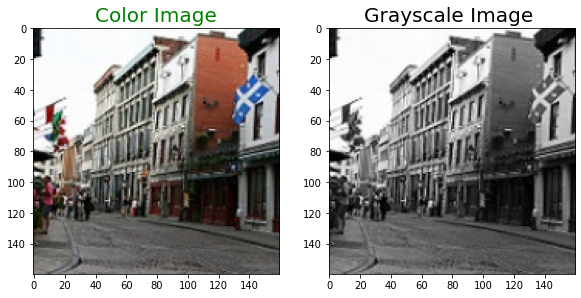

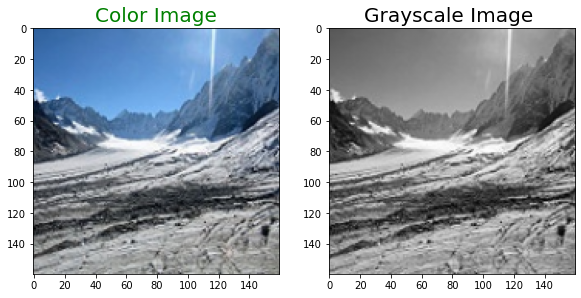

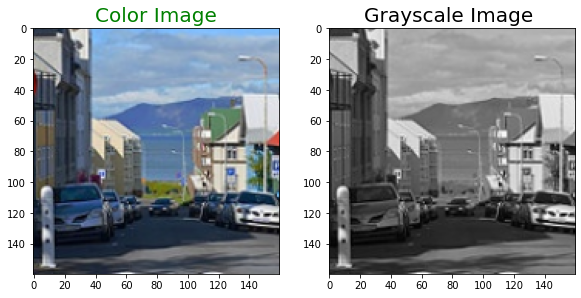

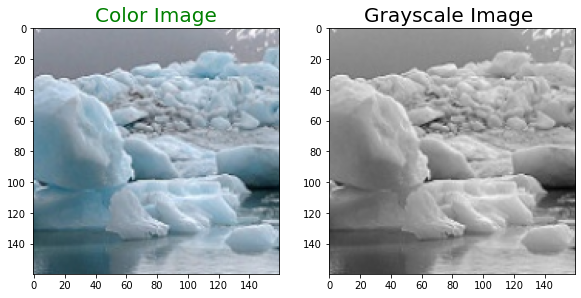

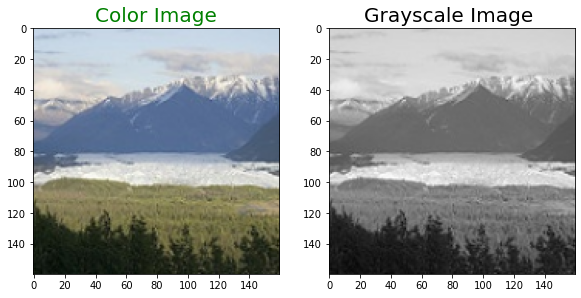

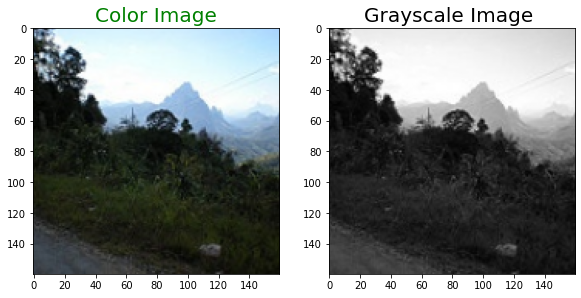

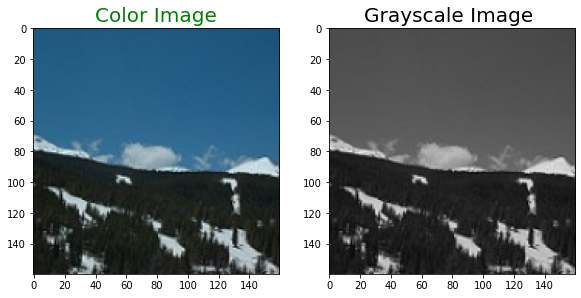

In [4]:
for i in range(3,10):
     plot_images(color_img[i],gray_img[i])

In [5]:
train_gray_image = gray_img[:4000]
train_color_image = color_img[:4000]

test_gray_image = gray_img[4000:]
test_color_image = color_img[4000:]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (4000, 160, 160, 3)
Test color image shape (500, 160, 160, 3)


In [6]:
from keras import layers
#########################
input_img = keras.Input(shape=(160, 160, 3))


x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)# 80*80
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
encoded = x

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=(2,2), activation='relu', padding='same')(x) #160*160
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)


output = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


In [7]:
model = keras.Model(input_img, output)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 80, 80, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 80, 80, 128)       73856     
                                                             

In [8]:
model.compile(optimizer='adam', loss='mean_absolute_error',metrics=['accuracy'])
model.fit(train_g, train_c,epochs=200,batch_size=50,validation_split=0.1)

Epoch 1/200
72/72 [==============================] - 28s 216ms/step - loss: 0.1363 - accuracy: 0.4263 - val_loss: 0.0840 - val_accuracy: 0.3755
Epoch 2/200
72/72 [==============================] - 14s 198ms/step - loss: 0.0780 - accuracy: 0.4039 - val_loss: 0.0755 - val_accuracy: 0.4576
Epoch 3/200
72/72 [==============================] - 15s 205ms/step - loss: 0.0698 - accuracy: 0.4699 - val_loss: 0.0679 - val_accuracy: 0.4738
Epoch 4/200
72/72 [==============================] - 14s 201ms/step - loss: 0.0652 - accuracy: 0.4809 - val_loss: 0.0641 - val_accuracy: 0.4875
Epoch 5/200
72/72 [==============================] - 14s 200ms/step - loss: 0.0621 - accuracy: 0.4808 - val_loss: 0.0652 - val_accuracy: 0.5034
Epoch 6/200
72/72 [==============================] - 14s 199ms/step - loss: 0.0605 - accuracy: 0.4801 - val_loss: 0.0601 - val_accuracy: 0.4998
Epoch 7/200
72/72 [==============================] - 14s 201ms/step - loss: 0.0590 - accuracy: 0.4807 - val_loss: 0.0593 - val_accuracy:

In [9]:
model.evaluate(test_gray_image,test_color_image)

16/16 [==============================] - 2s 86ms/step - loss: 0.0452 - accuracy: 0.5683


[0.045231208205223083, 0.5683319568634033]

1/1 [==============================] - 0s 358ms/step


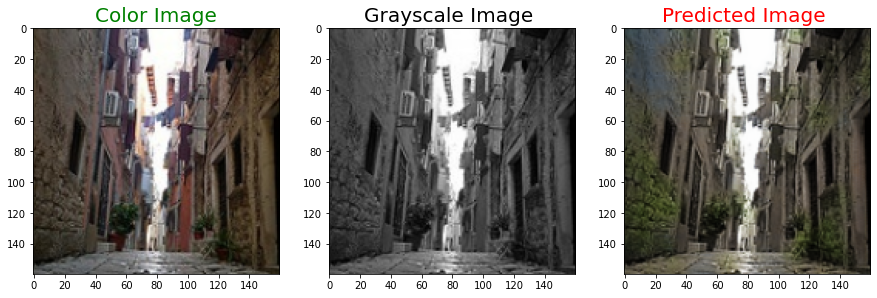

1/1 [==============================] - 0s 29ms/step


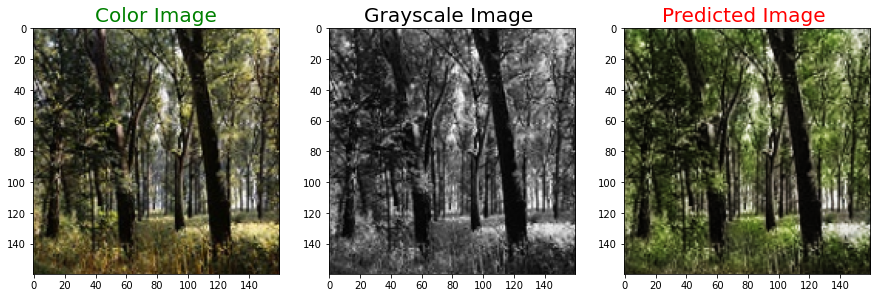

1/1 [==============================] - 0s 22ms/step


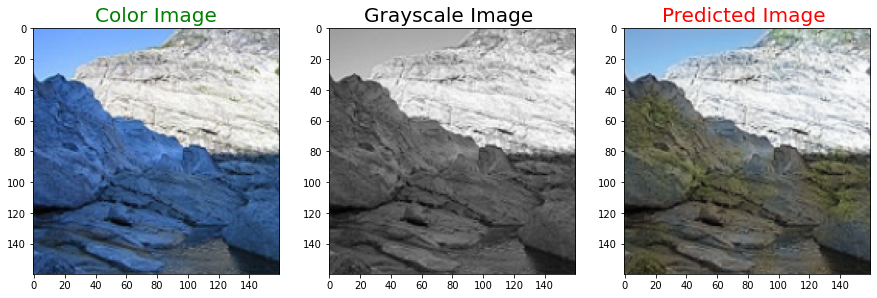

1/1 [==============================] - 0s 22ms/step


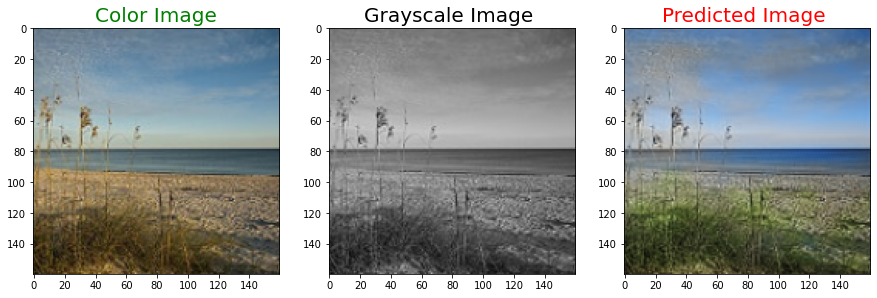

1/1 [==============================] - 0s 22ms/step


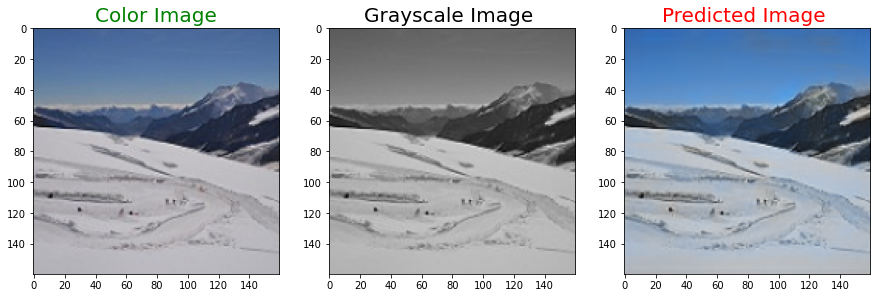

1/1 [==============================] - 0s 24ms/step


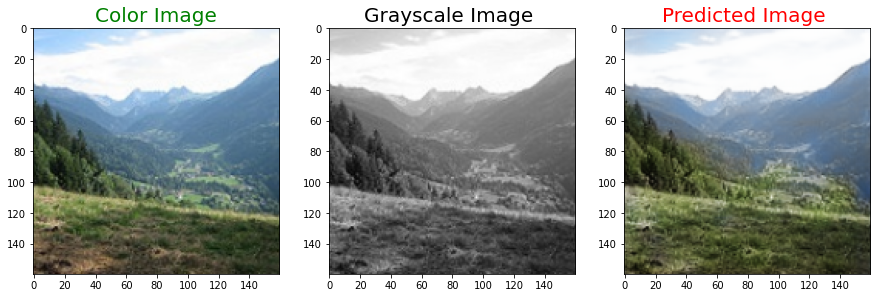

1/1 [==============================] - 0s 22ms/step


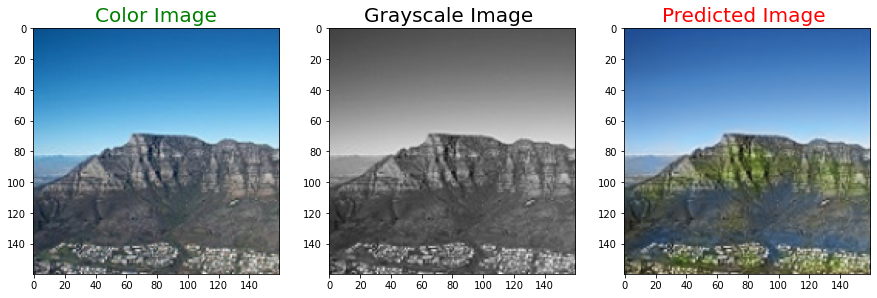

1/1 [==============================] - 0s 29ms/step


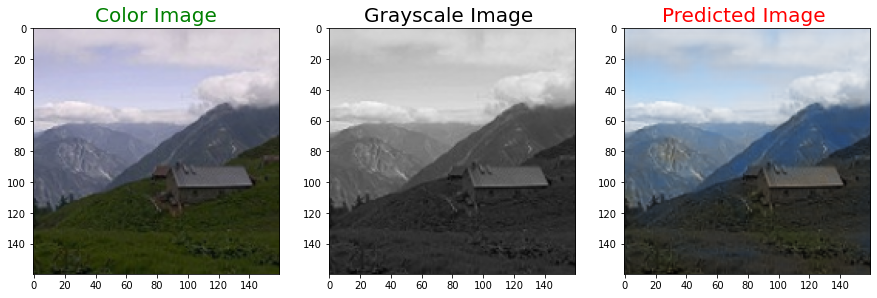

In [10]:
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(50,58):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)